# Introducing a validation loss
SPINN model to solve Fisher KPP on bounded domain in 1D.

**This notebook aims at introducing the usage of a validation in** **jinns**

$$
\begin{cases}
\frac{\partial}{\partial t} u(t,x)=D\frac{\partial^2}{\partial x^2} u(t,x) + u(t,x)(r(x) - \gamma(x)u(t,x)), t\geq 0, x\in [0,l]\\
u(t,0)=u(t,l)=0,t\geq 0, \text{Dirichlet condition}\\
u(0,x)=u_0(x),x\in [0,l]
\end{cases}
$$

In all that follows, $r(x)$, $\gamma(x)$ et $D$ are considered constant.

For more details about this experiment, see also the notebook _Fisher KPP on bounded domain in 1D (PINN and SPINN)_


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable


Import our package

In [3]:
import jinns


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


Create the neural network architecture for the PINN

Create the SPINN

In [5]:
d = 2
r = 256
eqx_list = [
    [eqx.nn.Linear, 1, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, 128],
    [jax.nn.tanh],
    [eqx.nn.Linear, 128, r],
]
key, subkey = random.split(key)
u_spinn = jinns.utils.create_SPINN(subkey, d, r, eqx_list, "nonstatio_PDE")

In [6]:
init_nn_params_spinn = u_spinn.init_params()

Create a DataGenerator object for the training data

In [7]:
n = 1000
nb = 2
nt = 1000
omega_batch_size = 32
temporal_batch_size = 32
omega_border_batch_size = 2
dim = 1
xmin = -1
xmax = 1
tmin = 0
tmax = 1
method = "uniform"

Tmax = 5
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)


## Set up the initial condition

Text(0.5, 1.0, 'Init condition $u_0$')

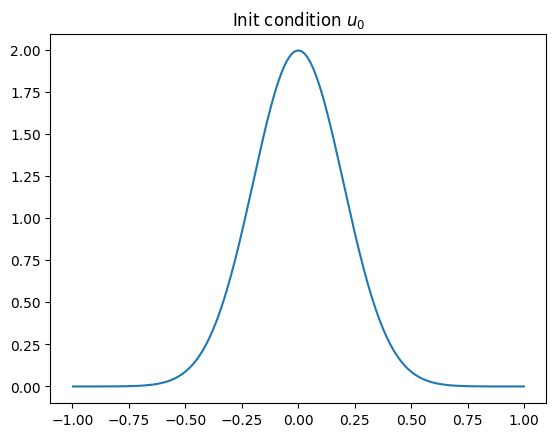

In [8]:
from jax.scipy.stats import norm
# true solution N(0,1)
sigma_init = 0.2 * jnp.ones((1))
mu_init = 0 * jnp.ones((1))

def u0(x):
    return jnp.squeeze(norm.pdf(x, loc=mu_init, scale=sigma_init))

plt.plot(train_data.omega.sort(axis=0), vmap(u0, (0), 0)(train_data.omega.sort(axis=0)))
plt.title(r"Init condition $u_0$")

## Model parameters

In [9]:
# Example III.29 is persistent with D = 1, r = 4,  g = 3
D = 1.
r = 4.
g = 3.
l = xmax - xmin
boundary_condition = "dirichlet"
omega_boundary_fun = lambda t, dx: 0 # cte func returning 0

A set of parameters as required by the losses' `evaluate` functions is a dictionary with the neural network parameters `nn_params` and the equation parameters `eq_params`. Here we construct this dictionary

In [10]:
init_params_spinn = {
    "nn_params":init_nn_params_spinn,
    "eq_params":{
        "D":jnp.array([D]),
        "r":jnp.array([r]),
        "g":jnp.array([g])
    }
}

## Loss construction

In [11]:
fisher_dynamic_loss = jinns.loss.FisherKPP(
    Tmax=Tmax
)

Loss for the SPINN

In [12]:
loss_weights = {"dyn_loss":1, "initial_condition": 1 * Tmax, "boundary_loss":1 * Tmax}

loss_spinn = jinns.loss.LossPDENonStatio(
    u=u_spinn,
    loss_weights=loss_weights,
    dynamic_loss=fisher_dynamic_loss,
    omega_boundary_fun=omega_boundary_fun,
    omega_boundary_condition=boundary_condition,
    initial_condition_fun=u0,
    norm_key=None,
    norm_borders=None,
    norm_samples=None
)

## Setting up the validation step

**Create a DataGenerator object for the validation data**: The same as for the train data but we do not want mini-batches over the validation dataset. We simply let the size of the batch be the total size of the dataset `omega_batch_size=n` and `temporal_batch_size=nt`.

In [13]:
n = 1000
nb = 2
nt = 1000
omega_batch_size = 1000
temporal_batch_size = 1000
omega_border_batch_size = 2 # Recall that the size here is irrelevant when the dimension of $\Omega$ is 1

Tmax = 5
key, subkey = random.split(key)
validation_data = jinns.data.CubicMeshPDENonStatio(
    subkey,
    n,
    nb,
    nt,
    omega_batch_size,
    omega_border_batch_size,
    temporal_batch_size,
    dim,
    (xmin,),
    (xmax,),
    tmin,
    tmax,
    method
)


Here, we work with a vanilla validation procedure already implemented in **jinns** by the `ValidationLoss` module. This consists of evaluating the whole loss on a validation dataset and optionally triggering (or not) an early stopping procedure. The `call_every` attribute represents how often the validation step is called during training, and the 
patience parameter controls how many non-improving validaiton iterations should be spent before early stoping. If `validation.early_stopping` is `False`, then we never break out of training and only return the monitored validation 
loss every `call_every` iterations.


**Note**: the **jinns** package allow user to define their own validation procedure on the form of `eqx.Module` (see [Equinox documentation](https://docs.kidger.site/equinox/api/module/module/)) with a `call_every` attribute and a `__call__(self, params)` method. For more details, look at the `ValidationLoss` module source code. It could be easily modified to focus on certain loss terms, or completely another criterion that user may find relevant for validation purpose, although we won't illustrate this in this Notebook.

In [14]:
from jinns.validation import ValidationLoss
validation = ValidationLoss(
    loss = loss_spinn, # a deep copy of `loss` will be done internally
    validation_data = validation_data,
    validation_param_data = None,
    validation_obs_data = None,
    call_every=250,
    early_stopping=True,
    patience=10
)

In [15]:
params_spinn = init_params_spinn
import optax
tx = optax.adamw(learning_rate=1e-4)
n_iter = 50000
params_spinn, train_loss_values, _, _, _, _, _, validation_loss_values = jinns.solve(
    init_params=params_spinn,
    data=train_data,
    optimizer=tx,
    loss=loss_spinn,
    n_iter=n_iter,
    validation=validation
)

[validation] Iteration 0: loss value = 5.329577922821045
[train] Iteration 0: loss value = 7.707352638244629
[validation] Iteration 1000: loss value = 1.7347807884216309
[train] Iteration 1000: loss value = 1.7712793350219727
[validation] Iteration 2000: loss value = 1.564159631729126
[train] Iteration 2000: loss value = 1.4535530805587769
[validation] Iteration 3000: loss value = 1.5742864608764648
[train] Iteration 3000: loss value = 1.5983805656433105
[validation] Iteration 4000: loss value = 1.4158320426940918
[train] Iteration 4000: loss value = 1.1813850402832031
[validation] Iteration 5000: loss value = 1.3331013917922974
[train] Iteration 5000: loss value = 1.4606316089630127
[validation] Iteration 6000: loss value = 1.2824040651321411
[train] Iteration 6000: loss value = 1.155892014503479
[validation] Iteration 7000: loss value = 1.3342020511627197
[train] Iteration 7000: loss value = 1.7245299816131592
[validation] Iteration 8000: loss value = 1.272660732269287
[train] Iterat

Note that `solve()` returns the `jnp.array` of our validation criterion as an extra argument (here the validation PINN loss) if `validation` is provided.

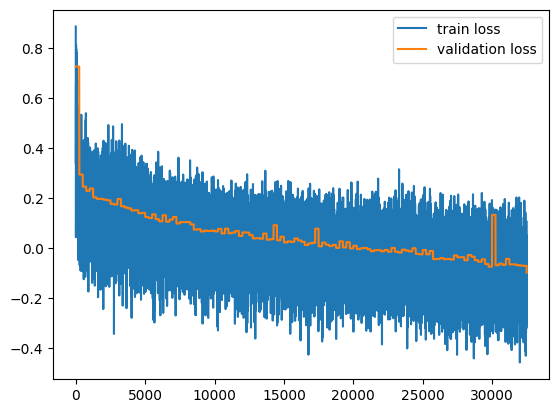

In [16]:
plt.plot(jnp.log10(train_loss_values), label="train loss")
plt.plot(jnp.log10(validation_loss_values), label="validation loss")
plt.legend()
plt.show()

In [17]:
nx = 500
val_xdata = jnp.linspace(xmin, xmax, nx)
ntime = 500
val_times = jnp.linspace(tmin, tmax, ntime)

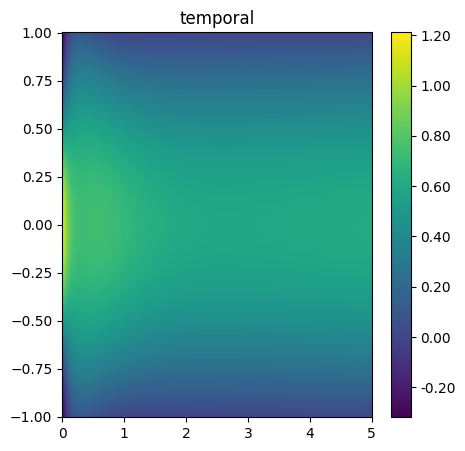

In [18]:
u_est_spinn = lambda t, x: u_spinn(t, x, params_spinn["nn_params"])
# same subkey
jinns.data.plot1d_image(u_est_spinn, xdata=val_xdata, times=val_times, Tmax=Tmax, cmap="viridis", colorbar=True, figsize=(5, 5), title="temporal", spinn=True)

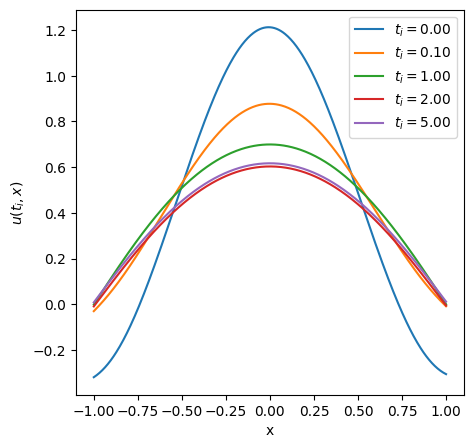

In [19]:
time_slices = [0, 0.02, 0.2, 0.4, 1]
jinns.data.plot1d_slice(u_est_spinn, xdata=val_xdata, time_slices=time_slices, Tmax=Tmax, figsize=(5, 5), spinn=True)